# ArXiv Veri Seti Analizi - RESUL CANCA 2202131033 

In [5]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

# 1. Veri Yükleme
file_path = 'arxiv_sample_5000.csv'
df = pd.read_csv(file_path)
print(f"Kaynak: '{file_path}' yolundan yüklendi.")
print(f"Toplam doküman: {df.shape[0]}, Dosya boyutu: {os.path.getsize(file_path)/(1024*1024):.2f} MB, Format: CSV")
print("Örnek ham veri:")
print(df[['id','abstract']].head(3).to_string(), "\n")

Kaynak: 'arxiv_sample_5000.csv' yolundan yüklendi.
Toplam doküman: 5000, Dosya boyutu: 1.35 MB, Format: CSV
Örnek ham veri:
                                                                                                                                                                                                                                                                                                                                                      id                                                                                                                                              abstract
0                                                                                                                                                                                                                                                                                                                                       arXiv:2405.00001  Necessary poor Mrs company. Almost 

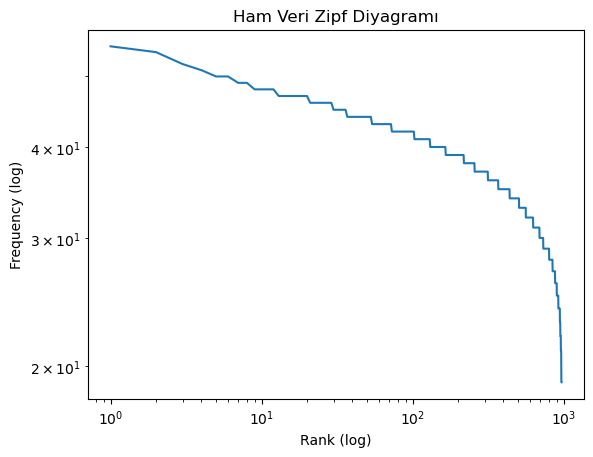

In [6]:
# 2. Ham Zipf Analizi
def zipf_plot(text, title):
    tokens = re.findall(r"\b[a-zA-Z]{2,}\b", text.lower())
    freq = Counter(tokens)
    dfz = pd.DataFrame(freq.items(), columns=['token','frequency']).sort_values('frequency',ascending=False)
    dfz['rank'] = range(1,len(dfz)+1)
    plt.loglog(dfz['rank'], dfz['frequency'])
    plt.xlabel('Rank (log)')
    plt.ylabel('Frequency (log)')
    plt.title(title)
    plt.show()

all_text = df['abstract'].dropna().str.cat(sep=' ')
zipf_plot(all_text, 'Ham Veri Zipf Diyagramı')


In [7]:
# 3. Ön İşleme Adımları
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
sw = set(stopwords.words('english'))

def preprocess(doc, do_stem=False, do_lemma=False):
    text = re.sub(r'<.*?>',' ', str(doc))
    text = re.sub(r'[^a-zA-Z\s]',' ', text).lower()
    tokens = text.split()
    tokens = [t for t in tokens if t not in sw]
    if do_lemma:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
    if do_stem:
        tokens = [stemmer.stem(t) for t in tokens]
    return ' '.join(tokens)

# Uygulama
df['stemmed'] = df['abstract'].fillna('').apply(lambda x: preprocess(x, do_stem=True))
df['lemmatized'] = df['abstract'].fillna('').apply(lambda x: preprocess(x, do_lemma=True))


In [8]:
# 4. Temiz Veriyi Kaydetme (Çalışma Dizinine)
stem_path = 'stemmed_data.csv'
lemma_path = 'lemmatized_data.csv'
df[['id','stemmed']].to_csv(stem_path, index=False)
df[['id','lemmatized']].to_csv(lemma_path, index=False)
print(f"Temizlenmiş veri CSV olarak kaydedildi: {stem_path}, {lemma_path}")


Temizlenmiş veri CSV olarak kaydedildi: stemmed_data.csv, lemmatized_data.csv


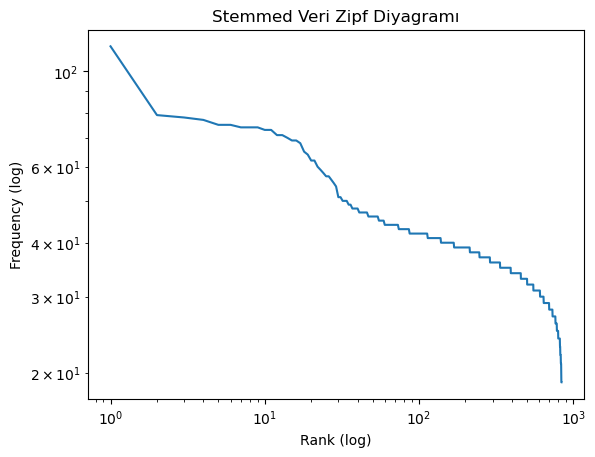

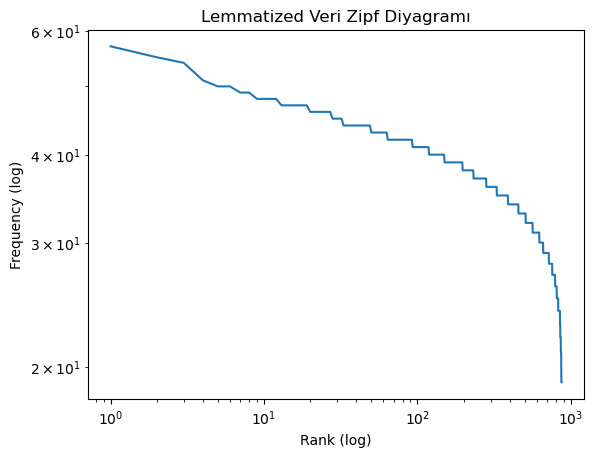

In [9]:
# 5. Temiz Veride Zipf Analizi
zipf_plot(' '.join(df['stemmed']), 'Stemmed Veri Zipf Diyagramı')
zipf_plot(' '.join(df['lemmatized']), 'Lemmatized Veri Zipf Diyagramı')

In [ ]:
# 6. TF-IDF Vektörleştirme
tfidf_params = {'max_df':0.8, 'min_df':5}
vectorizer = TfidfVectorizer(**tfidf_params)
X_stem = vectorizer.fit_transform(df['stemmed'])
stem_df = pd.DataFrame(X_stem.toarray(), columns=vectorizer.get_feature_names_out())
stem_tfidf_path = 'tfidf_stemmed.csv'
stem_df.to_csv(stem_tfidf_path, index=False)
X_lemma = vectorizer.fit_transform(df['lemmatized'])
lemma_df = pd.DataFrame(X_lemma.toarray(), columns=vectorizer.get_feature_names_out())
lemma_tfidf_path = 'tfidf_lemmatized.csv'
lemma_df.to_csv(lemma_tfidf_path, index=False)
print(f"TF-IDF CSV dosyaları oluşturuldu: {stem_tfidf_path}, {lemma_tfidf_path}")

In [ ]:
# 7. Word2Vec Modelleri Eğitimi
params = [
    {'model_type':'cbow','window':2,'vector_size':100},
    {'model_type':'skipgram','window':2,'vector_size':100},
    {'model_type':'cbow','window':4,'vector_size':100},
    {'model_type':'skipgram','window':4,'vector_size':100},
    {'model_type':'cbow','window':2,'vector_size':300},
    {'model_type':'skipgram','window':2,'vector_size':300},
    {'model_type':'cbow','window':4,'vector_size':300},
    {'model_type':'skipgram','window':4,'vector_size':300}
]

def train_save_w2v(corpus, suffix):
    sentences = [doc.split() for doc in corpus]
    for p in params:
        sg = 0 if p['model_type']=='cbow' else 1
        model = Word2Vec(sentences, vector_size=p['vector_size'], window=p['window'], sg=sg, workers=4)
        name = f"word2vec_{suffix}_{p['model_type']}_win{p['window']}_dim{p['vector_size']}.model"
        model.save(name)
        print(f"Model kaydedildi: {name}")
        print(model.wv.most_similar(positive=['data'], topn=5))

# Eğitimi Başlat
train_save_w2v(df['stemmed'], 'stemmed')
train_save_w2v(df['lemmatized'], 'lemmatized')

print("Tüm modeller çalışma dizinine kaydedildi.")